In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] No tochinfo found...Installing it")
  !pip install -q torchinfo
  from  torchinfo import summary

try:
  from going_modular import data_setup, engine
except:
  print('Downloading from GitHub')
  !git clone https://github.com/yusufbekYuldashev/PytorchForDL
  !mv PytorchForDL/going_modular .
  !rm -rf PytorchForDL
  from going_modular import data_setup, engine

[INFO] No tochinfo found...Installing it
Cloning into 'PytorchForDL'...
remote: Enumerating objects: 827, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 827 (delta 13), reused 30 (delta 5), pack-reused 786
Receiving objects: 100% (827/827), 162.02 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (971/971), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!python going_modular/get_data.py

Creating one
Downloading
Unzipping


In [5]:
from pathlib import Path
import os

data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
### manual transform creation for dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir, test_dir, transform, BATCH_SIZE, NUM_WORKERS)

In [7]:
### automatic transform creation for dataloaders based on the pretrained model weights being used
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir, test_dir, auto_transform, 32)
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## 2. Choosing a model
Things to consider:
 1. Speed
 2. Size
 3. Performance

In [8]:
# OLD way: prior to torchvision v0.13
# model = torchvision.models.efficientnet_b0(pretrained=True)

# NEW way: after torchvision v0.13
# workaround starts
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
  kwargs.pop("check_hash")
  return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict
# workaround ends

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 85.0MB/s]


In [9]:
summary(model, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [10]:
# setting parameters frozen/ untrainable
for param in model.features.parameters():
  param.requires_grad = False

summary(model, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)
summary(model, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 3. Training model

In [13]:
%load_ext autoreload
%autoreload 2
from going_modular import engine
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = timer()
results = engine.train(model, train_dataloader, test_dataloader, optimizer, device, loss_fn, 5)
end = timer()
print(f"Model took: {end-start} on {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting training


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0---------------------------------
Epoch: 0 Train acc: 0.69 Train Loss: 0.8812 Test Acc: 0.85 Test Loss: 0.6841
Epoch: 1---------------------------------
Epoch: 1 Train acc: 0.86 Train Loss: 0.7334 Test Acc: 0.93 Test Loss: 0.6072
Epoch: 2---------------------------------
Epoch: 2 Train acc: 0.84 Train Loss: 0.6588 Test Acc: 0.94 Test Loss: 0.5504
Epoch: 3---------------------------------
Epoch: 3 Train acc: 0.77 Train Loss: 0.6326 Test Acc: 0.95 Test Loss: 0.4717
Epoch: 4---------------------------------
Epoch: 4 Train acc: 0.80 Train Loss: 0.5550 Test Acc: 0.93 Test Loss: 0.4476
Model took: 17.27099289600028 on cuda


## 4. Evaluation

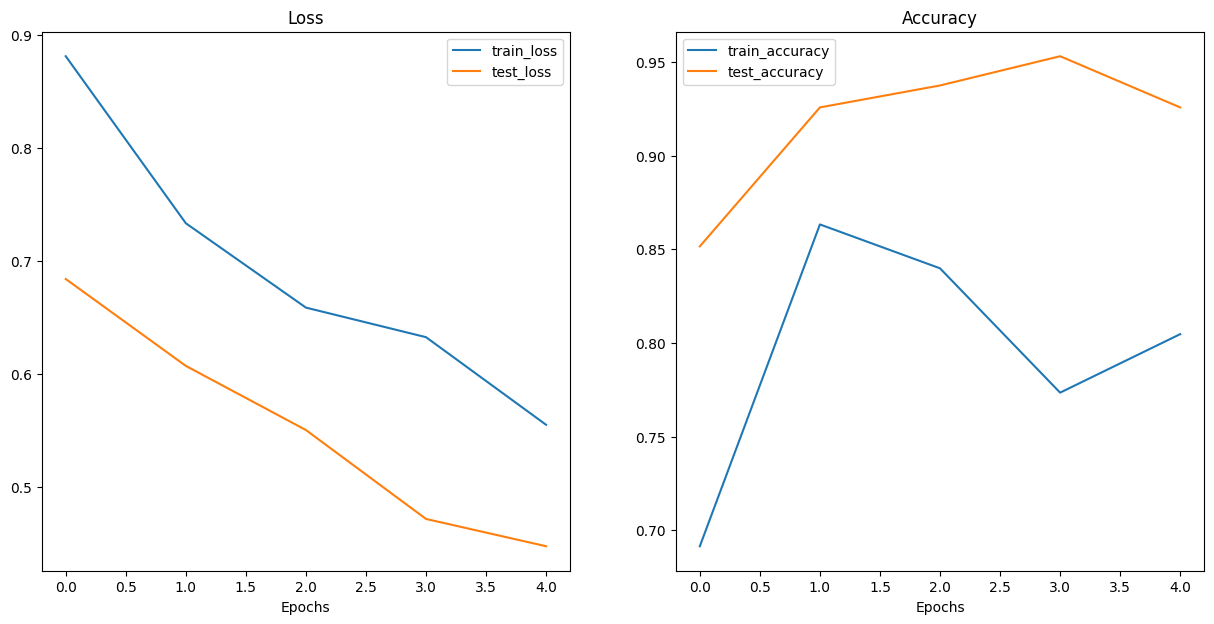

In [14]:
import requests

try:
  from helper_functions import plot_loss_curves
except:
  with open('helper_functions.py', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

[PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'), PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]


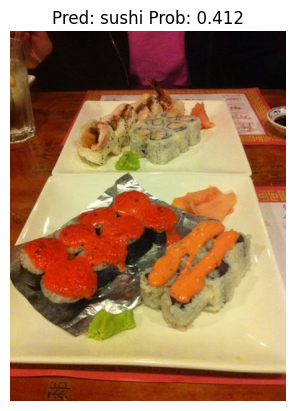

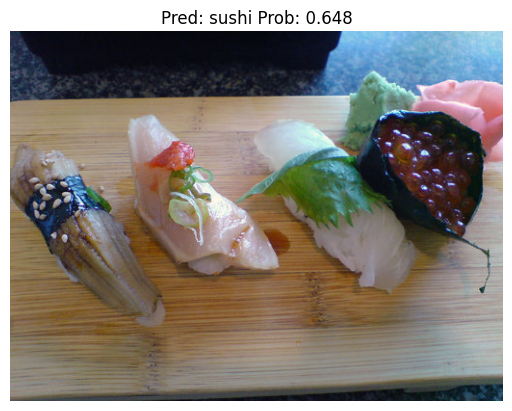

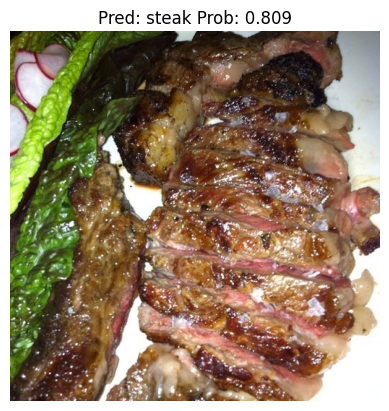

In [26]:
from going_modular import utils
import random

num_imgs = 3
test_img_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_simple = random.sample(population=test_img_list, k=num_imgs)
# print(test_img_simple)
for img_path in test_img_simple:
    utils.pred_and_plot_image(model, img_path, class_names, device=device)

data/04-pizza-dad.jpeg already exists, skipping downloading...


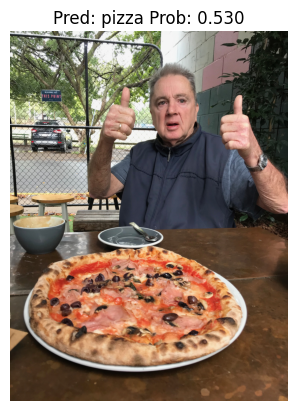

In [31]:
import requests

custom_image_path = data_path/"04-pizza-dad.jpeg"
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
        print(f"Download {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping downloading...")

utils.pred_and_plot_image(model, custom_image_path, class_names)